In [157]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # MATLAB-like way of plotting

# useful scikit-learn functions
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# for brevity import specific keras objects
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout, Input
from sklearn.metrics import mean_squared_error


In [158]:
# for repeatable results:
from tensorflow.random import set_seed
from random import seed
SEED = 3
seed(SEED)
np.random.seed(SEED)
set_seed(SEED)

In [159]:
def splitSequence(seq, n_steps):
    #Declare X and y as empty list
    X = []
    y = []
    for i in range(len(seq)):
        #get the last index
        lastIndex = i + n_steps
        #if lastIndex is greater than length of sequence then break
        if lastIndex > len(seq) - 1:
            break
        #Create input and output sequence
        seq_X, seq_y = seq[i:lastIndex], seq[lastIndex]
        #append seq_X, seq_y in X and y list
        X.append(seq_X)
        y.append(seq_y)
        pass
    #Convert X and y into numpy array
    X = np.array(X)
    y = np.array(y)

    return X,y

In [160]:
# read the data from file
data = pd.read_csv('sunspots_data.csv')
sunspots_data = data.iloc[:-100]

holdout = data[-100:]  # Last 100 points

In [161]:
# seperate out some of the data for validation
t_end = 2200
sunspots_data_train = sunspots_data.iloc[:t_end+1,1].values.reshape(-1,1)
sunspots_data_test = sunspots_data.iloc[t_end:,1].values.reshape(-1,1)

In [162]:
sunspots_data_train[:5]

array([[ 96.7],
       [104.3],
       [116.7],
       [ 92.8],
       [141.7]])

In [163]:
sunspots_data_test[:5]

array([[29.7],
       [36.9],
       [16. ],
       [11.3],
       [ 6.6]])

In [164]:
# scale the data and save the scaling so we can invert later
scaler = MinMaxScaler()
scaler.fit(sunspots_data_train)
scaler.fit(sunspots_data_test)
sunspots_data_train = scaler.transform(sunspots_data_train)
sunspots_data_test = scaler.transform(sunspots_data_test)

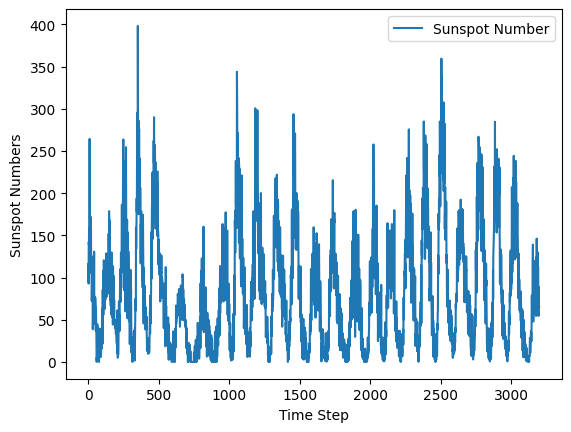

In [165]:
# plot the training and validation data
sunspots_data.plot()
plt.xlabel('Time Step')
plt.ylabel('Sunspot Numbers')
plt.savefig('test_plot.png')


In [166]:
# decide on the number of steps to be fed into model
n_steps = 5

In [167]:
# generate inputs (X) and outputs (y)
X_train, y_train = splitSequence(sunspots_data_train, n_steps)
X_test, y_test = splitSequence(sunspots_data_test, n_steps)

In [168]:
# reshape into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [169]:
print(X_train.shape)
print(X_test.shape)

(2196, 5, 1)
(994, 5, 1)


In [170]:
# Define the model
model = Sequential()

# Add Input layer
model.add(Input(shape=(n_steps, n_features)))

# Add LSTM layers with Dropout
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=32))
model.add(Dropout(0.2))

# Add Dense layer for output
model.add(Dense(units=1))

# Show model summary
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 5, 32)          │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 5, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,025 (82.13 KB)

 Trainable params: 21,025 (82.13 KB)

 Non-trainable params: 0 (0.00 B)

In [171]:
# compile the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# fit the model
history = model.fit(X_train, y_train, epochs = 5, batch_size=32, validation_data = (X_test,y_test), verbose=0)

# # Access the history object
# print(history.history)

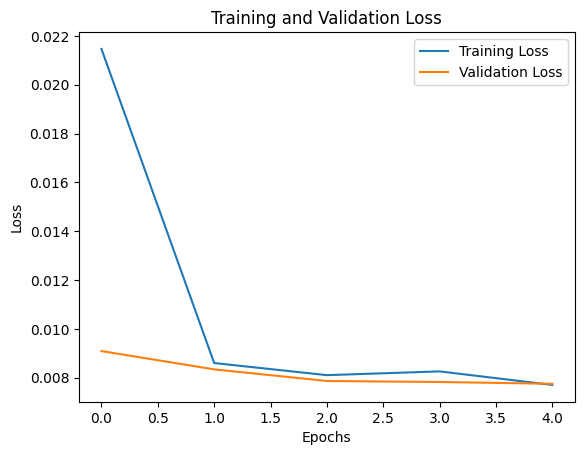

In [172]:
# Extract loss values
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [173]:
# evaluate model
loss = model.evaluate(X_test, y_test, verbose=0)
print(loss)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# invert the scaling back to the original
y_train = scaler.inverse_transform(y_train.reshape(-1,1))
y_test = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_train = scaler.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test = scaler.inverse_transform(y_pred_test.reshape(-1,1))

actual = np.append(y_train, y_test)
prediction = np.append(y_pred_train, y_pred_test)

0.007752921897917986
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step


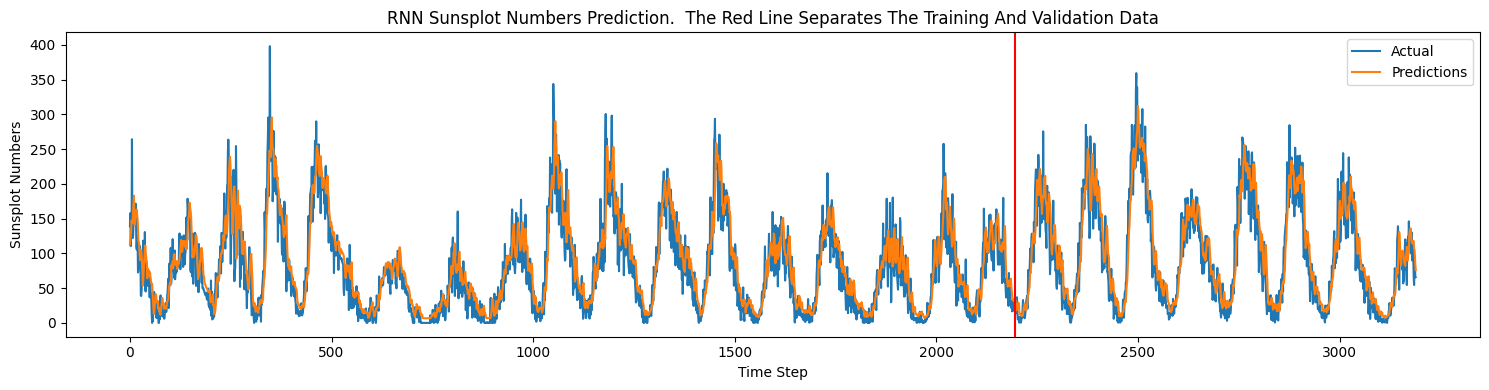

In [174]:
# plot the sequence and predictions
fig, ax = plt.subplots(1,1, figsize=(15, 4))
ax.plot(actual, label='Actual')
ax.plot(prediction, label='Predictions')

ax.axvline(x=len(y_train), color='r')
ax.legend()
ax.set_xlabel('Time Step')
ax.set_ylabel('Sunsplot Numbers')
ax.set_title('RNN Sunsplot Numbers Prediction.  ' +
    'The Red Line Separates The Training And Validation Data')

fig.tight_layout()

fig.savefig('Sunsplot_Numbers_plot.png')

In [177]:
# Select the numeric column (e.g., 'Sunspot Number')
holdout_numeric = holdout['Sunspot Number'].values.reshape(-1, 1)

# Apply scaling
holdout_scaled = scaler.transform(holdout_numeric)

# Generate input-output sequences
X_holdout, y_holdout = splitSequence(holdout_scaled, n_steps)

# Predict on holdout data
y_pred_holdout = model.predict(X_holdout)

# Inverse scale predictions and actual values for comparison
y_pred_holdout = scaler.inverse_transform(y_pred_holdout)
y_holdout = scaler.inverse_transform(y_holdout.reshape(-1, 1))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [179]:
y_pred_holdout[:5]

array([[75.703354],
       [75.48067 ],
       [68.864075],
       [66.78243 ],
       [63.806664]], dtype=float32)

In [180]:
y_holdout[:5]

array([[57. ],
       [56.4],
       [54.1],
       [37.9],
       [51.5]])

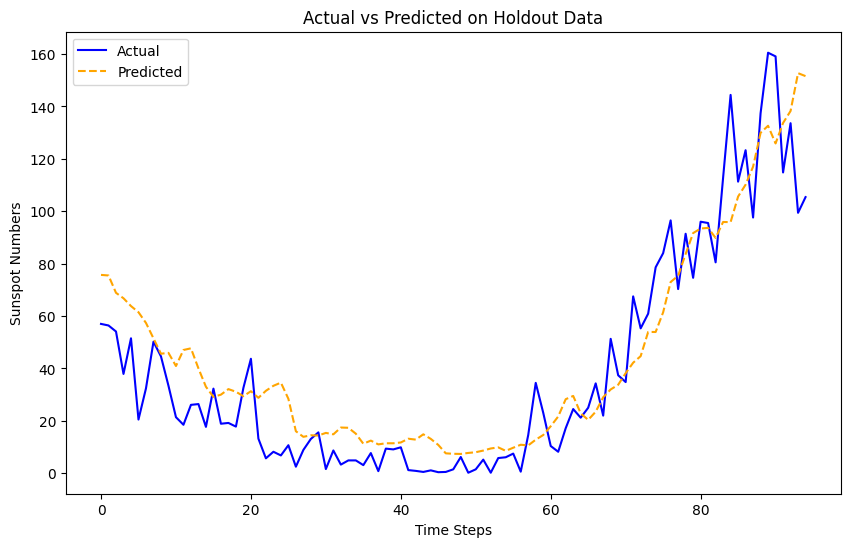

In [181]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_holdout, label='Actual', color='blue')
plt.plot(y_pred_holdout, label='Predicted', color='orange', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Sunspot Numbers')
plt.title('Actual vs Predicted on Holdout Data')
plt.legend()
plt.show()
